In [3]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
import glob
from matplotlib.colors import LogNorm

In [159]:
# Load in the pmaps from the data

pmaps_data = load_pmaps_as_df("../data/run_13837_0000_ldc1_trg0_irene.h5")

s1_pmaps_data = pmaps_data[0]
s2_pmaps_data = pmaps_data[1]

# want event 37
display(s1_pmaps_data)

,event,peak,time,bwidth,ene
0,9,0,366725.0,25.0,0.403061
1,9,0,366750.0,25.0,0.288837
2,9,0,366775.0,25.0,0.050455
3,9,0,366800.0,25.0,0.296073
4,9,0,366825.0,25.0,0.700088
...,...,...,...,...,...
16967,464,13,527050.0,25.0,0.468331
16968,464,13,527075.0,25.0,0.485518
16969,464,13,527100.0,25.0,0.145230
16970,464,13,527125.0,25.0,0.009676


In [234]:
# Load in the MC
pmaps_mc = load_pmaps_as_df("../data/NEXT100_Ar_alpha_profile_5.6MeV_hypathia_v2.h5")
# pmaps_mc = load_pmaps_as_df("../data/NEXT100_Ar_alpha_profile_5.6MeV_0.0001_imp_EL_hypathia.h5")
s1_pmaps_mc = pmaps_mc[0]
s2_pmaps_mc = pmaps_mc[1]

# Load in the MC
pmaps_mc_simple = load_pmaps_as_df("../data/NEXT100_Ar_alpha_profile_5.6MeV_0.0001_imp_hypathia.h5")
s1_s1_pmaps_mc_simple = pmaps_mc_simple[0]
s2_s1_pmaps_mc_simple = pmaps_mc_simple[1]

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_36380/35750762.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1s_data["time"] = s1s_data["time"] -960.75e3
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_36380/35750762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2s_data["time"] = s2s_data["time"] -960.75e3


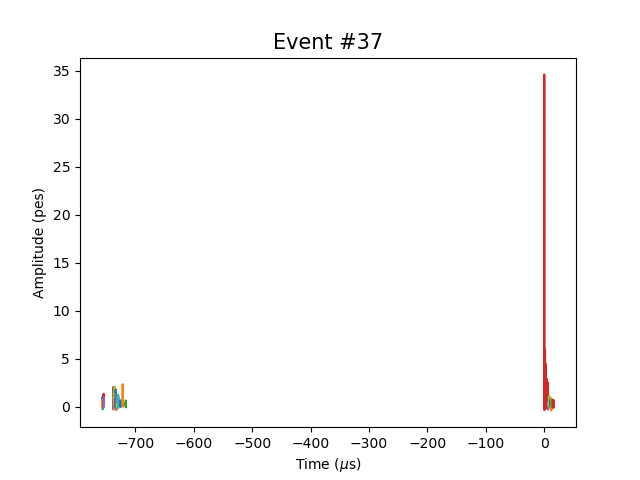

In [235]:
s1s_data, s2s_data, s2sis, s1pmts, s2pmts = pmaps_data
s1s_data   = s1s_data  .loc[lambda df: df.event == 37]
s2s_data   = s2s_data  .loc[lambda df: df.event == 37]
s2sis = s2sis.loc[lambda df: df.event == 37]

s1s_data["time"] = s1s_data["time"] -960.75e3
s2s_data["time"] = s2s_data["time"] -960.75e3

plt.figure()

for _, s1 in s1s_data.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


# for _, s2 in s2s_data.groupby("peak"):
#     plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice


# plt.plot(s1s_data[s1s_data.peak == 23].time / 1e3, s1s_data[s1s_data.peak == 23].ene)
# plt.plot(s2s[s2s.peak == 10].time / 1e3, s2s[s2s.peak == 10].ene)

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.title(f"Event #{37}", fontsize=15);

# plt.xlim(-1,1)

Text(0, 0.5, 'Amplitude (pes)')

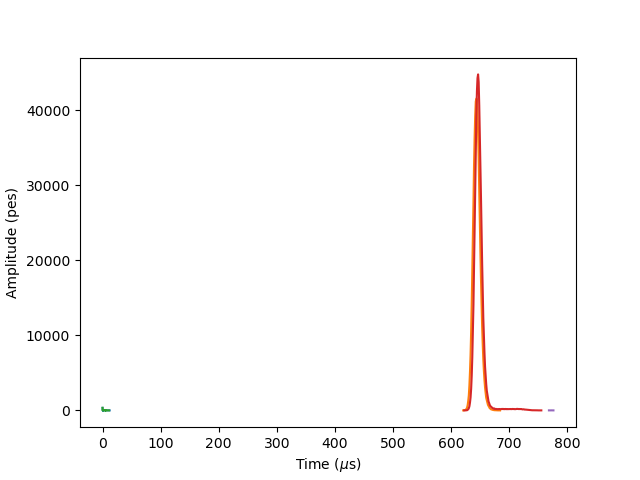

In [236]:
%matplotlib widget
s1s_mc, s2s_mc, s2sis, s1pmts, s2pmts = pmaps_mc
s1s_mc   = s1s_mc  .loc[lambda df: df.event == 0]
s2s_mc   = s2s_mc  .loc[lambda df: df.event == 0]
s2sis = s2sis.loc[lambda df: df.event == 0]

s1s_mc["time"] = s1s_mc["time"] -10e3
s2s_mc["time"] = s2s_mc["time"] -10e3

for _, s1 in s1s_mc.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


for _, s2 in s2s_mc.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice



s1s_mc_simple, s2s_mc_simple, s2sis, s1pmts, s2pmts = pmaps_mc_simple
s1s_mc_simple   = s1s_mc_simple  .loc[lambda df: df.event == 0]
s2s_mc_simple   = s2s_mc_simple  .loc[lambda df: df.event == 0]
s2sis = s2sis.loc[lambda df: df.event == 0]

s1s_mc_simple["time"] = s1s_mc_simple["time"] -10e3
s2s_mc_simple["time"] = s2s_mc_simple["time"] -10e3

for _, s1 in s1s_mc_simple.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


for _, s2 in s2s_mc_simple.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice



# plt.plot(s1s[s1s.peak == 23].time / 1e3, s1s[s1s.peak == 23].ene)
# plt.plot(s2s[s2s.peak == 10].time / 1e3, s2s[s2s.peak == 10].ene)

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")

Text(0, 0.5, 'Energy [PE]')

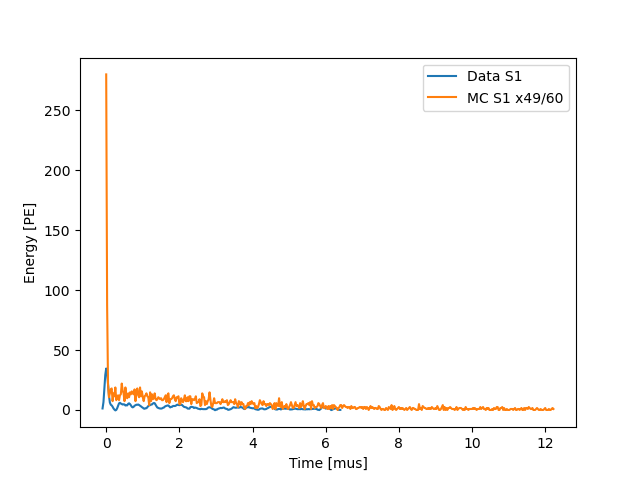

In [253]:
plt.figure()

plt.plot(s1s_data[s1s_data.peak == 23].time / 1e3, s1s_data[s1s_data.peak == 23].ene, label = "Data S1")
# plt.plot(s2s_data[s2s_data.peak == 10].time / 1e3, s2s_data[s2s_data.peak == 10].ene, label = "Data S2")

plt.plot(s1s_mc[s1s_mc.peak == 0].time / 1e3, s1s_mc[s1s_mc.peak == 0].ene*49/60, label = "MC S1 x49/60")
# plt.plot( (s2s_mc[s2s_mc.peak == 0].time / 1e3), s2s_mc[s2s_mc.peak == 0].ene*49/60, label = "MC Prof S2 \nx49/60, shift 4.8mus")


# plt.plot(s1s_mc[s1s_mc.peak == 0].time / 1e3, s1s_mc[s1s_mc.peak == 0].ene*49/60, label = "MC Simp S1 x49/60")
# plt.plot(s2s_mc_simple[s2s_mc_simple.peak == 0].time / 1e3+2, s2s_mc_simple[s2s_mc_simple.peak == 0].ene*49/60,linestyle="--",  label = "MC Simp S2 \nx49/60 x0.62, shift 4.8mus")

plt.legend()

plt.xlabel("Time [mus]")
plt.ylabel("Energy [PE]")
# plt.xlim(630, 700)


Text(0, 0.5, 'Energy [PE]')

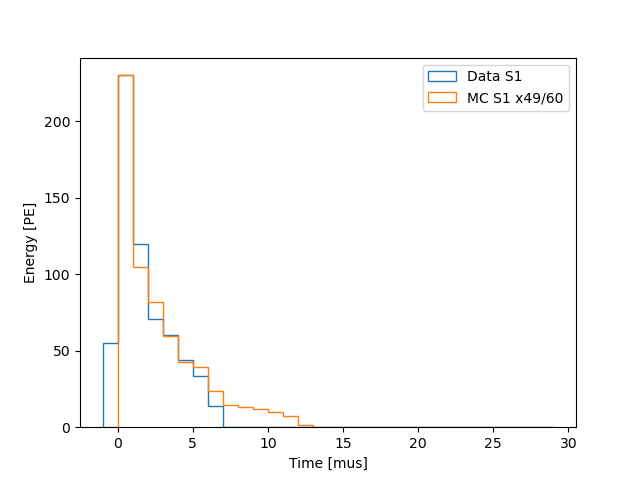

In [254]:
plt.figure()

plt.hist(s1s_data[s1s_data.peak == 23].time / 1e3, weights = s1s_data[s1s_data.peak == 23].ene, label = "Data S1", histtype ="step", bins = np.arange(-1,30,1))
plt.hist(s1s_mc[s1s_mc.peak == 0].time / 1e3,      weights = s1s_mc[s1s_mc.peak == 0].ene*49/60*0.26, label = "MC S1 x49/60", histtype ="step", bins = np.arange(-1,30,1))
plt.legend()

plt.xlabel("Time [mus]")
plt.ylabel("Energy [PE]")